In [1]:
%matplotlib inline
import gc, math, pickle, datetime, os, random
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from IPython.display import display
from statistics import *
from datetime import datetime
import seaborn as sns
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer
import lightgbm as lgb

In [2]:
def reduce_mem_usage(df, verbose=True):
    """
    :param df: Dataframe with columns unprocessed so they use more memory than needed
    
    :returns:
        df -> Dataframe with lower memory use
    """
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# Predictions lower than zero are turned zero
def fix_predictions(y):
    """
    :param y: Column with predictions
    """
    y[y < 0] = 0

In [3]:
# use data from cleaned v2
df_train = pd.read_csv('E:/data/Kaggle Energy Prediction/train_cleaned_part2.csv')

In [4]:
df_train.dtypes

Unnamed: 0                            int64
Unnamed: 0.1                          int64
building_id                           int64
meter                                 int64
timestamp                            object
meter_reading                       float64
hour                                  int64
meter_avg                           float64
meter_std                           float64
meter_reading_diff_from_avg         float64
meter_hour_avg                      float64
meter_hour_std                      float64
meter_reading_hour_diff_from_avg    float64
weekday                               int64
month                                 int64
is_weekend                            int64
site_id                               int64
primary_use                          object
square_feet                           int64
year_built                          float64
floor_count                         float64
air_temperature                     float64
cloud_coverage                  

In [5]:
del df_train['Unnamed: 0']
del df_train['Unnamed: 0.1']
df_train.shape

(20216100, 43)

In [6]:
df_train = reduce_mem_usage(df_train)

Mem. usage decreased to 1927.96 Mb (70.9% reduction)


In [7]:
df_train.head()

,building_id,meter,timestamp,meter_reading,hour,meter_avg,meter_std,meter_reading_diff_from_avg,meter_hour_avg,meter_hour_std,...,hour_adj_meter2_rank,hour_adj_meter3_rank,hour_meter0_rank,hour_meter1_rank,hour_meter2_rank,hour_meter3_rank,month_meter0_rank,month_meter1_rank,month_meter2_rank,month_meter3_rank
0,0,0,2016-01-01 00:00:00,0.0,0,170.875,380.83432,-170.825638,149.75,322.885773,...,7.0,14.0,5.0,6.0,10.0,14.0,2.0,1.0,7.0,12.0
1,1,0,2016-01-01 00:00:00,0.0,0,170.875,380.83432,-170.825638,149.75,322.885773,...,7.0,14.0,5.0,6.0,10.0,14.0,2.0,1.0,7.0,12.0
2,2,0,2016-01-01 00:00:00,0.0,0,170.875,380.83432,-170.825638,149.75,322.885773,...,7.0,14.0,5.0,6.0,10.0,14.0,2.0,1.0,7.0,12.0
3,3,0,2016-01-01 00:00:00,0.0,0,170.875,380.83432,-170.825638,149.75,322.885773,...,7.0,14.0,5.0,6.0,10.0,14.0,2.0,1.0,7.0,12.0
4,4,0,2016-01-01 00:00:00,0.0,0,170.875,380.83432,-170.825638,149.75,322.885773,...,7.0,14.0,5.0,6.0,10.0,14.0,2.0,1.0,7.0,12.0


In [15]:
# Extract mapping table for testing data
df_site_cluster_map = df_train[['site_id', 'cluster']].groupby(['site_id', 'cluster']).size().reset_index()
df_building_cluster_map = df_train[['building_id', 'building_cluster']].groupby(['building_id', 'building_cluster']).size().reset_index()
df_hour_rank_map = df_train[['hour', 'hour_meter0_rank', 'hour_meter1_rank', 'hour_meter2_rank', 'hour_meter3_rank']].groupby(['hour', 'hour_meter0_rank', 'hour_meter1_rank', 'hour_meter2_rank', 'hour_meter3_rank']).size().reset_index()
df_hour_adj_rank_map = df_train[['hour_adj', 'hour_adj_meter0_rank', 'hour_adj_meter1_rank', 'hour_adj_meter2_rank', 'hour_adj_meter3_rank']].groupby(['hour_adj', 'hour_adj_meter0_rank', 'hour_adj_meter1_rank', 'hour_adj_meter2_rank', 'hour_adj_meter3_rank']).size().reset_index()
df_month_rank_map = df_train[['month', 'month_meter0_rank', 'month_meter1_rank', 'month_meter2_rank', 'month_meter3_rank']].groupby(['month', 'month_meter0_rank', 'month_meter1_rank', 'month_meter2_rank', 'month_meter3_rank']).size().reset_index()

In [21]:
df_site_cluster_map.to_csv('E:/data/Kaggle Energy Prediction/site_id_weather_cluster.csv')
df_building_cluster_map.to_csv('E:/data/Kaggle Energy Prediction/building_id_cluster.csv')
df_hour_rank_map.to_csv('E:/data/Kaggle Energy Prediction/hour_rank.csv')
df_hour_adj_rank_map.to_csv('E:/data/Kaggle Energy Prediction/hour_adj_rank.csv')
df_month_rank_map.to_csv('E:/data/Kaggle Energy Prediction/month_rank.csv')

## 0. Prepare Train and Validation Data

In [22]:
def myOneHotCode(df, colList):
    
    for col in colList:
        for i in df[col].unique():
            print(i)
            colname = col + '_' + str(i)
            print('added : ', colname)
            df[colname] = np.where(df[col] == i, 1, 0)
            
    return df

In [23]:
df_train = myOneHotCode(df_train, ['cluster', 'building_cluster'])
df_train = pd.concat([df_train , pd.get_dummies(df_train['primary_use']) ], axis=1)
del df_train['primary_use']
df_train.head()

2
added :  cluster_2
0
added :  cluster_0
1
added :  cluster_1
4
added :  building_cluster_4
0
added :  building_cluster_0
2
added :  building_cluster_2
3
added :  building_cluster_3
1
added :  building_cluster_1


,building_id,meter,timestamp,meter_reading,hour,meter_avg,meter_std,meter_reading_diff_from_avg,meter_hour_avg,meter_hour_std,...,Office,Other,Parking,Public services,Religious worship,Retail,Services,Technology/science,Utility,Warehouse/storage
0,0,0,2016-01-01 00:00:00,0.0,0,170.875,380.83432,-170.825638,149.75,322.885773,...,0,0,0,0,0,0,0,0,0,0
1,1,0,2016-01-01 00:00:00,0.0,0,170.875,380.83432,-170.825638,149.75,322.885773,...,0,0,0,0,0,0,0,0,0,0
2,2,0,2016-01-01 00:00:00,0.0,0,170.875,380.83432,-170.825638,149.75,322.885773,...,0,0,0,0,0,0,0,0,0,0
3,3,0,2016-01-01 00:00:00,0.0,0,170.875,380.83432,-170.825638,149.75,322.885773,...,0,0,0,0,0,0,0,0,0,0
4,4,0,2016-01-01 00:00:00,0.0,0,170.875,380.83432,-170.825638,149.75,322.885773,...,0,0,0,0,0,0,0,0,0,0


In [24]:
#add year, and is_year_after_year_built
df_train['year'] = pd.to_datetime(df_train['timestamp']).dt.year
df_train['is_after_year_built'] = np.where(df_train['year'] > df_train['year_built'], 1, 0)
df_train[['year', 'is_after_year_built']].head()

,year,is_after_year_built
0,2016,1
1,2016,1
2,2016,1
3,2016,1
4,2016,1


In [25]:
gc.collect()

132

In [26]:
train_y = df_train[['meter', 'meter_reading']]
del df_train['meter_reading']
df_train['meter'] = train_y['meter']

In [27]:
test_size = 0.20
X_train, X_val, y_train, y_val = train_test_split(df_train, train_y, test_size=test_size, random_state=2)

In [28]:
del df_train
gc.collect()

77

In [29]:
X_train['timestamp'] = pd.to_numeric(pd.to_datetime(X_train['timestamp']))
X_val['timestamp'] = pd.to_numeric(pd.to_datetime(X_val['timestamp']))

In [31]:
del X_train['meter_reading_diff_from_avg']
del X_val['meter_reading_diff_from_avg']
del X_train['meter_reading_hour_diff_from_avg']
del X_val['meter_reading_hour_diff_from_avg']
del X_train['building_id']
del X_val['building_id']
del X_train['meter_reading_per_sqfeet']
del X_val['meter_reading_per_sqfeet']
del X_train['site_id']
del X_val['site_id']
del X_train['meter_avg']
del X_val['meter_avg']
del X_train['meter_std']
del X_val['meter_std']
del X_train['meter_hour_avg']
del X_val['meter_hour_avg']
del X_train['meter_hour_std']
del X_val['meter_hour_std']

In [32]:
X_train.to_csv('E:/data/Kaggle Energy Prediction/train_cleaned_part2_X_train.csv')
X_val.to_csv('E:/data/Kaggle Energy Prediction/train_cleaned_part2_X_val.csv')
y_train.to_csv('E:/data/Kaggle Energy Prediction/train_cleaned_part2_y_train.csv')
y_val.to_csv('E:/data/Kaggle Energy Prediction/train_cleaned_part2_y_val.csv')

## 1. Regression Model

## 2. LightGBM Model

### a) on all meter type

In [66]:
#  lgb_params = {
#                    'objective':'regression',
#                    'boosting_type':'gbdt',
#                    'metric':'rmse',
#                    'n_jobs':-1,
#                    'learning_rate':0.07,
#                    'num_leaves': 2**8,
#                    'max_depth':-1,
#                    'tree_learner':'serial',
#                    'colsample_bytree': 0.7,
#                    'subsample_freq':1,
#                    'subsample':0.5,
#                    'n_estimators':8500,
#                    'max_bin':255,
#                    'verbose':1,
#                    'seed': 2,
#                    'early_stopping_rounds':3500, 
#                } 



In [75]:
# lgb_train = lgb.Dataset(X_train, y_train['meter_reading'])
# lgb_eval = lgb.Dataset(X_val, y_val['meter_reading'])
# gbm = lgb.train(
#            lgb_params,
#            lgb_train,
#            num_boost_round=5000,
#            valid_sets=(lgb_train, lgb_eval),
#            verbose_eval = 50
#            )

C:\Users\td073\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\td073\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 3500 rounds
[50]	training's rmse: 24890.1	valid_1's rmse: 29331
[100]	training's rmse: 18379.2	valid_1's rmse: 25523.3
[150]	training's rmse: 15118.7	valid_1's rmse: 24430.9
[200]	training's rmse: 12890.3	valid_1's rmse: 23653.1
[250]	training's rmse: 11296.8	valid_1's rmse: 23343.6
[300]	training's rmse: 10013.4	valid_1's rmse: 23086.5
[350]	training's rmse: 8908.04	valid_1's rmse: 22880
[400]	training's rmse: 8058.44	valid_1's rmse: 22664
[450]	training's rmse: 7327.24	valid_1's rmse: 22567.8
[500]	training's rmse: 6735.38	valid_1's rmse: 22551.4
[550]	training's rmse: 6217.98	valid_1's rmse: 22498
[600]	training's rmse: 5752.19	valid_1's rmse: 22451.6
[650]	training's rmse: 5332.17	valid_1's rmse: 22408.4
[700]	training's rmse: 4968.94	valid_1's rmse: 22363.5
[750]	training's rmse: 4647.67	valid_1's rmse: 22392.7
[800]	training's rmse: 4369.33	valid_1's rmse: 22379.1
[850]	training's rmse: 4113.25	valid_1's rmse: 22387.3
[900]	train

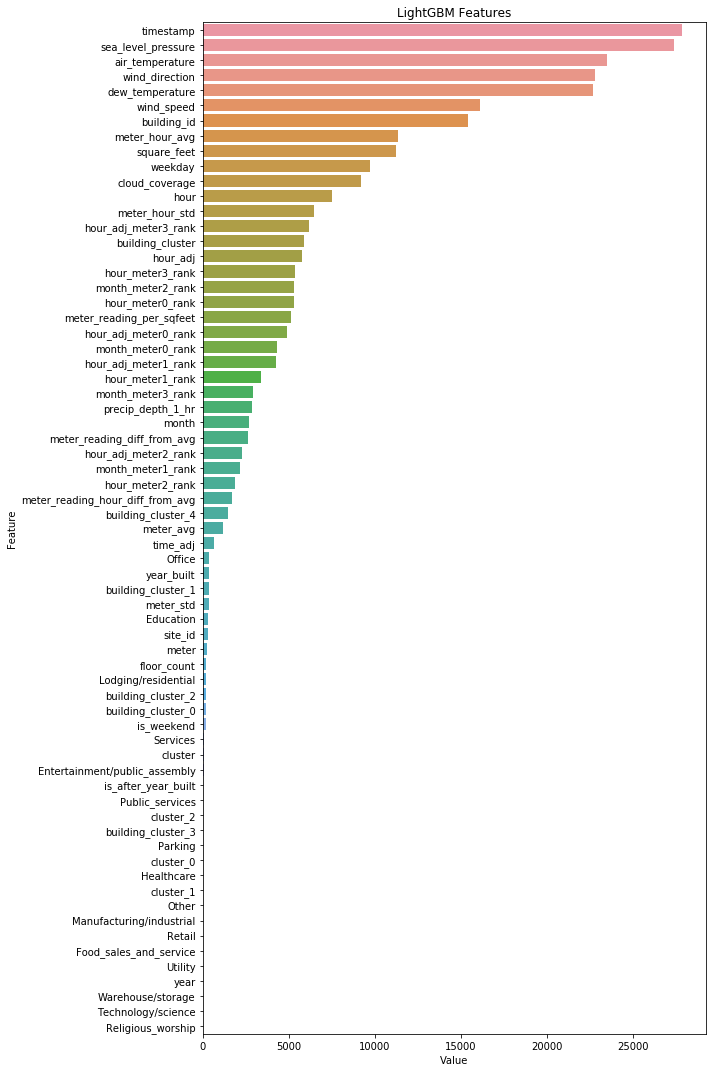

In [77]:
# feature_imp = pd.DataFrame(sorted(zip(gbm.feature_importance(), gbm.feature_name()),reverse = True), columns=['Value','Feature'])
# plt.figure(figsize=(10, 15))
# sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
# plt.title('LightGBM Features')
# plt.tight_layout()
# plt.show()

In [80]:
# y_pred = gbm.predict(X_val, num_iteration=gbm.best_iteration)
# fix_predictions(y_pred)
# rmsle = np.sqrt(mean_squared_log_error(y_pred, (y_val.meter_reading)))
# print('RMSLE: ', rmsle)

RMSLE:  0.8715093640731986


In [82]:
# gbm.save_model('E:/data/Kaggle Energy Prediction/lgb_classifier_{}_{}.txt'.format(datetime.now().strftime("%d-%m-%Y"), rmsle), num_iteration=gbm.best_iteration)

#### building four models separately

building model for meter  0


C:\Users\td073\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\td073\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 3500 rounds
[50]	training's rmse: 31.0488	valid_1's rmse: 18.9038
[100]	training's rmse: 25.4082	valid_1's rmse: 12.9845
[150]	training's rmse: 23.1104	valid_1's rmse: 11.7024
[200]	training's rmse: 21.4836	valid_1's rmse: 12.0303
[250]	training's rmse: 20.0748	valid_1's rmse: 12.3096
[300]	training's rmse: 18.6827	valid_1's rmse: 11.6063
[350]	training's rmse: 17.9692	valid_1's rmse: 11.8236
[400]	training's rmse: 17.0991	valid_1's rmse: 12.4669
[450]	training's rmse: 15.9725	valid_1's rmse: 12.0639
[500]	training's rmse: 15.4139	valid_1's rmse: 11.973
[550]	training's rmse: 14.8124	valid_1's rmse: 11.7281
[600]	training's rmse: 14.2804	valid_1's rmse: 12.2861
[650]	training's rmse: 13.6527	valid_1's rmse: 11.964
[700]	training's rmse: 13.2662	valid_1's rmse: 12.0449
[750]	training's rmse: 12.8788	valid_1's rmse: 12.1704
[800]	training's rmse: 12.3868	valid_1's rmse: 12.0638
[850]	training's rmse: 11.9931	valid_1's rmse: 12.0971
[900]

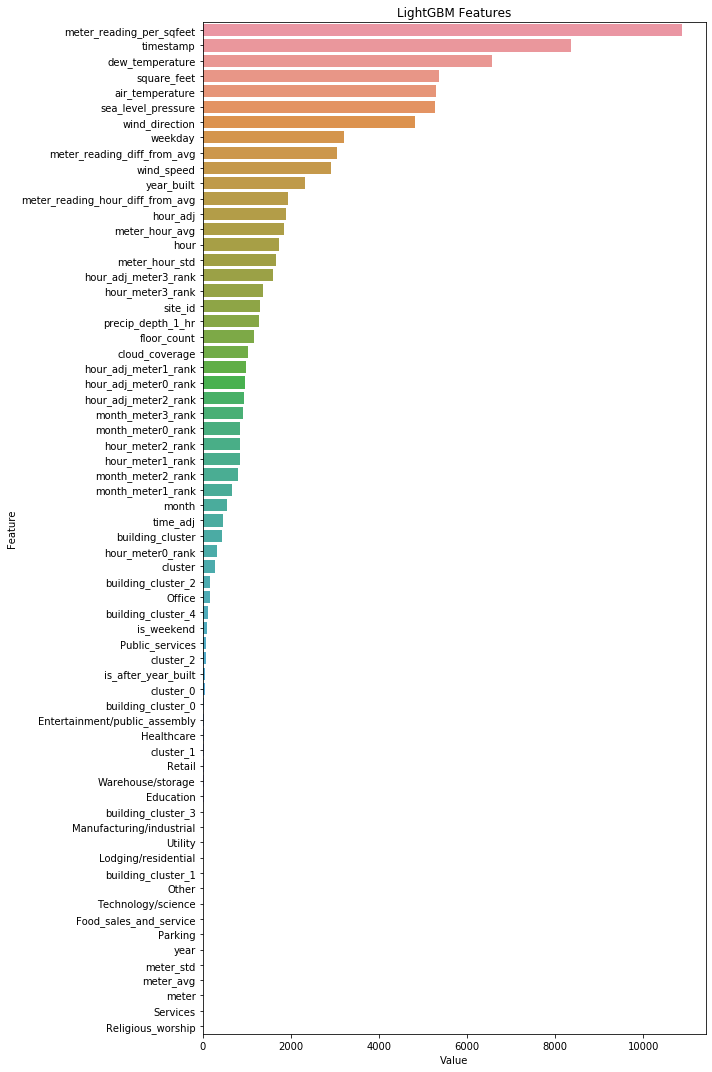

RMSLE:  0.07208208917053027
building model for meter  1


C:\Users\td073\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\td073\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 3500 rounds
[50]	training's rmse: 978.13	valid_1's rmse: 1195.74
[100]	training's rmse: 788.118	valid_1's rmse: 1091.22
[150]	training's rmse: 692.051	valid_1's rmse: 1062.61
[200]	training's rmse: 621.376	valid_1's rmse: 1045.06
[250]	training's rmse: 568.034	valid_1's rmse: 1030.35
[300]	training's rmse: 525.649	valid_1's rmse: 1030.55
[350]	training's rmse: 491.368	valid_1's rmse: 1016.08
[400]	training's rmse: 460.569	valid_1's rmse: 1018.08
[450]	training's rmse: 433.107	valid_1's rmse: 1019.22
[500]	training's rmse: 408.416	valid_1's rmse: 1023.82
[550]	training's rmse: 385.661	valid_1's rmse: 1025.44
[600]	training's rmse: 363.771	valid_1's rmse: 1030.73
[650]	training's rmse: 344.386	valid_1's rmse: 1025.35
[700]	training's rmse: 328.081	valid_1's rmse: 1021.05
[750]	training's rmse: 312.024	valid_1's rmse: 1021.38
[800]	training's rmse: 296.447	valid_1's rmse: 1021.4
[850]	training's rmse: 282.82	valid_1's rmse: 1020.16
[900]	

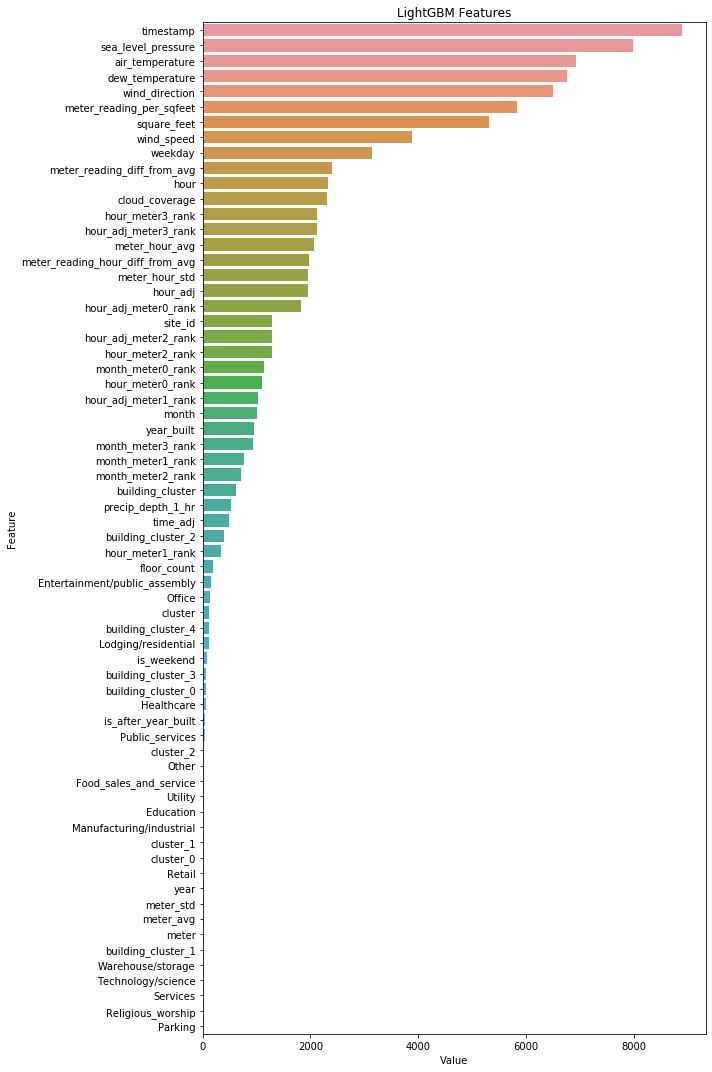

RMSLE:  0.37804389307625663
building model for meter  2


C:\Users\td073\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\td073\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 3500 rounds
[50]	training's rmse: 66628.2	valid_1's rmse: 76961.7
[100]	training's rmse: 49129.5	valid_1's rmse: 66518.5
[150]	training's rmse: 40146.7	valid_1's rmse: 62878.1
[200]	training's rmse: 34019.9	valid_1's rmse: 61196.3
[250]	training's rmse: 29732.8	valid_1's rmse: 59834.2
[300]	training's rmse: 26003.1	valid_1's rmse: 59388
[350]	training's rmse: 23254.2	valid_1's rmse: 58937.2
[400]	training's rmse: 20892.6	valid_1's rmse: 58446.7
[450]	training's rmse: 18881.1	valid_1's rmse: 58108.8
[500]	training's rmse: 17175.3	valid_1's rmse: 58064.6
[550]	training's rmse: 15696.9	valid_1's rmse: 57929.2
[600]	training's rmse: 14552.5	valid_1's rmse: 57773.7
[650]	training's rmse: 13403	valid_1's rmse: 57706.5
[700]	training's rmse: 12460.8	valid_1's rmse: 57712.7
[750]	training's rmse: 11604.1	valid_1's rmse: 57683.8
[800]	training's rmse: 10819.2	valid_1's rmse: 57653.6
[850]	training's rmse: 10124.7	valid_1's rmse: 57651.5
[900]	t

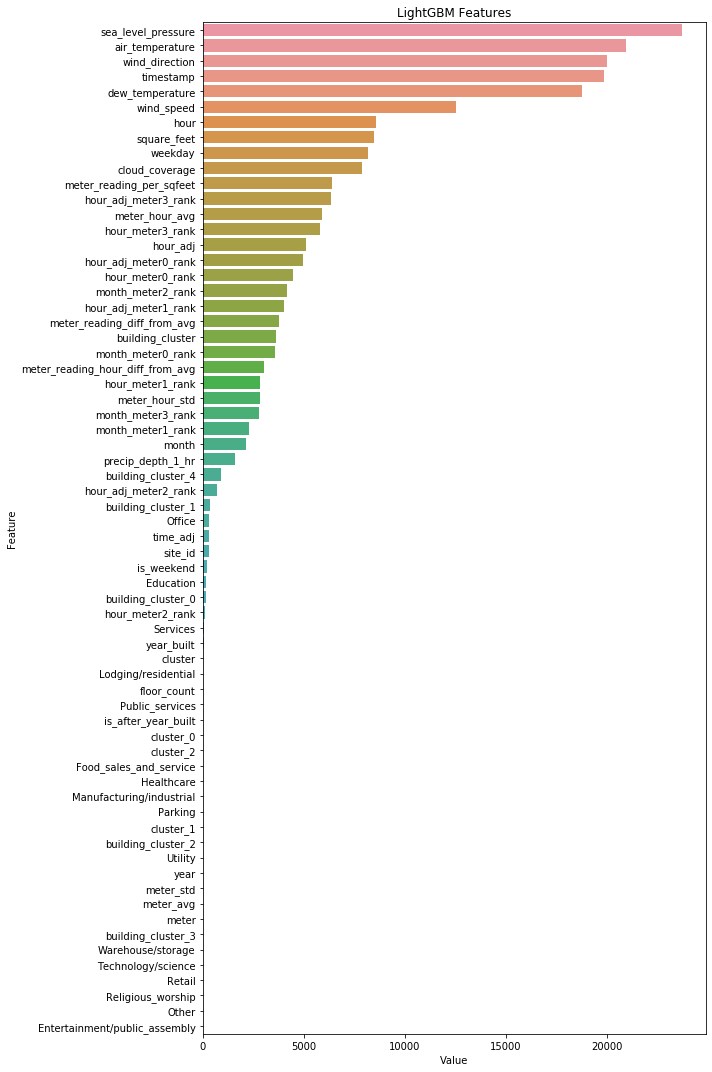

RMSLE:  1.040659790971021
building model for meter  3


C:\Users\td073\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\td073\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 3500 rounds
[50]	training's rmse: 557.071	valid_1's rmse: 717.711
[100]	training's rmse: 455.843	valid_1's rmse: 696.616
[150]	training's rmse: 390.571	valid_1's rmse: 697.164
[200]	training's rmse: 340.198	valid_1's rmse: 698
[250]	training's rmse: 299.961	valid_1's rmse: 700.39
[300]	training's rmse: 267.358	valid_1's rmse: 703.463
[350]	training's rmse: 238.973	valid_1's rmse: 704.41
[400]	training's rmse: 214.35	valid_1's rmse: 708.484
[450]	training's rmse: 194.562	valid_1's rmse: 709.105
[500]	training's rmse: 177.467	valid_1's rmse: 712.531
[550]	training's rmse: 161.672	valid_1's rmse: 712.954
[600]	training's rmse: 147.947	valid_1's rmse: 715.073
[650]	training's rmse: 136.418	valid_1's rmse: 715.182
[700]	training's rmse: 125.116	valid_1's rmse: 715.488
[750]	training's rmse: 115.362	valid_1's rmse: 716.754
[800]	training's rmse: 106.892	valid_1's rmse: 717.535
[850]	training's rmse: 99.6425	valid_1's rmse: 718.318
[900]	trai

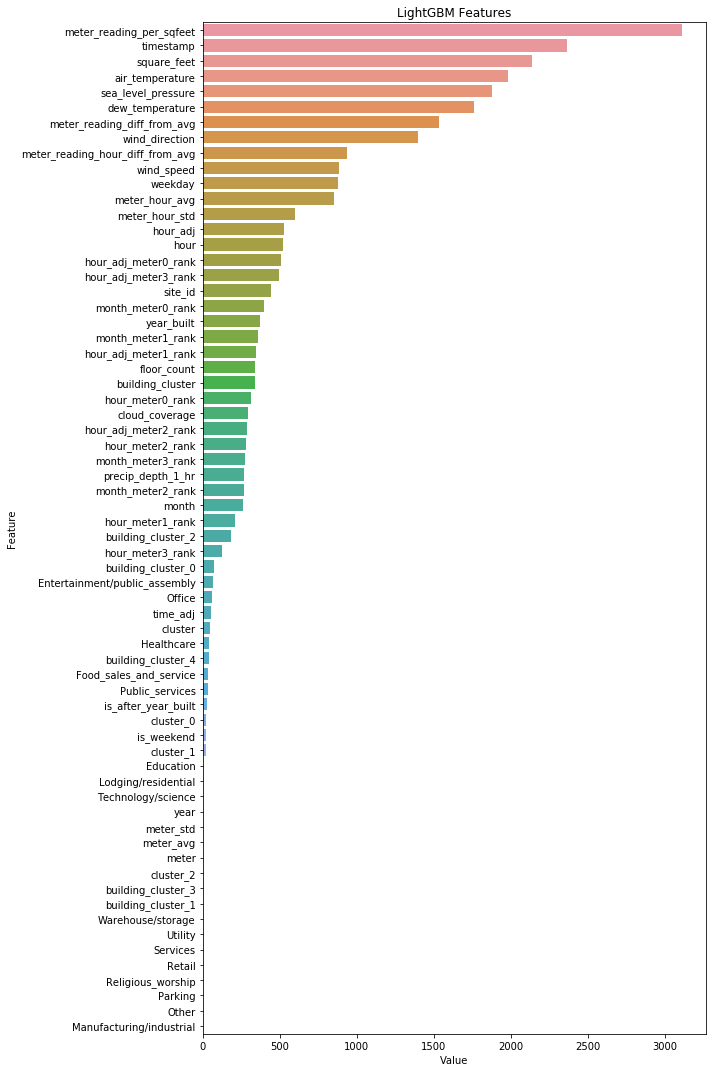

RMSLE:  0.3108315700635017


In [85]:
# meter_type = [0, 1, 2, 3]
# y_val_rmsle = []
# #

# for i, meter_type in enumerate(meter_type):
#     print('building model for meter ', meter_type)
#     lgb_train = lgb.Dataset(X_train.loc[X_train.meter == meter_type ,], y_train.loc[y_train.meter == meter_type ,'meter_reading'])
#     lgb_eval = lgb.Dataset(X_val.loc[X_val.meter == meter_type ,], y_val.loc[y_val.meter == meter_type ,'meter_reading'])
#     gbm = lgb.train(
#                lgb_params,
#                lgb_train,
#                num_boost_round=5000,
#                valid_sets=(lgb_train, lgb_eval),
#                verbose_eval = 50
#                )

#     feature_imp = pd.DataFrame(sorted(zip(gbm.feature_importance(), gbm.feature_name()),reverse = True), columns=['Value','Feature'])
#     plt.figure(figsize=(10, 15))
#     sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
#     plt.title('LightGBM Features')
#     plt.tight_layout()
#     plt.show()

#     y_pred = gbm.predict(X_val.loc[X_val.meter == meter_type ,], num_iteration=gbm.best_iteration)
#     fix_predictions(y_pred)
#     rmsle = np.sqrt(mean_squared_log_error(y_pred, (y_val.loc[y_val.meter == meter_type ,'meter_reading'])))
#     print('RMSLE: ', rmsle)
    
#     y_val_rmsle.append(rmsle)

#     gbm.save_model('E:/data/Kaggle Energy Prediction/lgb_classifier_{}_{}_{}.txt'.format(datetime.now().strftime("%d-%m-%Y"), rmsle, meter_type), num_iteration=gbm.best_iteration)

    
# testing_result = pd.DataFrame({'meter_type':meter_type, 'rmsle':y_val_rmsle})

In [91]:
# testing_result

,meter_type,rmsle
0,3,0.072082
1,3,0.378044
2,3,1.040660
3,3,0.310832


#### taking log of meter_reading and rerun

In [104]:
# del X_train['meter_reading_diff_from_avg']
# del X_val['meter_reading_diff_from_avg']
# del X_train['meter_reading_hour_diff_from_avg']
# del X_val['meter_reading_hour_diff_from_avg']

# for i in X_train.columns:
#     print(i)

In [33]:
gc.collect()

75

In [106]:
del lgb_train
del lgb_eval

building model for meter  0


C:\Users\td073\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\td073\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 3500 rounds
[50]	training's rmse: 0.59144	valid_1's rmse: 0.590882
[100]	training's rmse: 0.470395	valid_1's rmse: 0.470425
[150]	training's rmse: 0.424267	valid_1's rmse: 0.424596
[200]	training's rmse: 0.398843	valid_1's rmse: 0.39958
[250]	training's rmse: 0.382825	valid_1's rmse: 0.384038
[300]	training's rmse: 0.369818	valid_1's rmse: 0.371369
[350]	training's rmse: 0.359823	valid_1's rmse: 0.36173
[400]	training's rmse: 0.351758	valid_1's rmse: 0.354124
[450]	training's rmse: 0.345703	valid_1's rmse: 0.348391
[500]	training's rmse: 0.33954	valid_1's rmse: 0.342626
[550]	training's rmse: 0.333768	valid_1's rmse: 0.337226
[600]	training's rmse: 0.329153	valid_1's rmse: 0.332955
[650]	training's rmse: 0.32503	valid_1's rmse: 0.329162
[700]	training's rmse: 0.321257	valid_1's rmse: 0.325668
[750]	training's rmse: 0.31766	valid_1's rmse: 0.322427
[800]	training's rmse: 0.314286	valid_1's rmse: 0.319387
[850]	training's rmse: 0.311344	

[7150]	training's rmse: 0.240001	valid_1's rmse: 0.27281
[7200]	training's rmse: 0.239827	valid_1's rmse: 0.272743
[7250]	training's rmse: 0.239718	valid_1's rmse: 0.272761
[7300]	training's rmse: 0.239594	valid_1's rmse: 0.272772
[7350]	training's rmse: 0.23951	valid_1's rmse: 0.272794
[7400]	training's rmse: 0.239408	valid_1's rmse: 0.27281
[7450]	training's rmse: 0.239289	valid_1's rmse: 0.272816
[7500]	training's rmse: 0.239175	valid_1's rmse: 0.272831
[7550]	training's rmse: 0.239055	valid_1's rmse: 0.272869
[7600]	training's rmse: 0.238878	valid_1's rmse: 0.272808
[7650]	training's rmse: 0.238724	valid_1's rmse: 0.272804
[7700]	training's rmse: 0.238624	valid_1's rmse: 0.272811
[7750]	training's rmse: 0.238528	valid_1's rmse: 0.272815
[7800]	training's rmse: 0.238426	valid_1's rmse: 0.272868
[7850]	training's rmse: 0.238303	valid_1's rmse: 0.272839
[7900]	training's rmse: 0.238133	valid_1's rmse: 0.272842
[7950]	training's rmse: 0.238038	valid_1's rmse: 0.272861
[8000]	training's

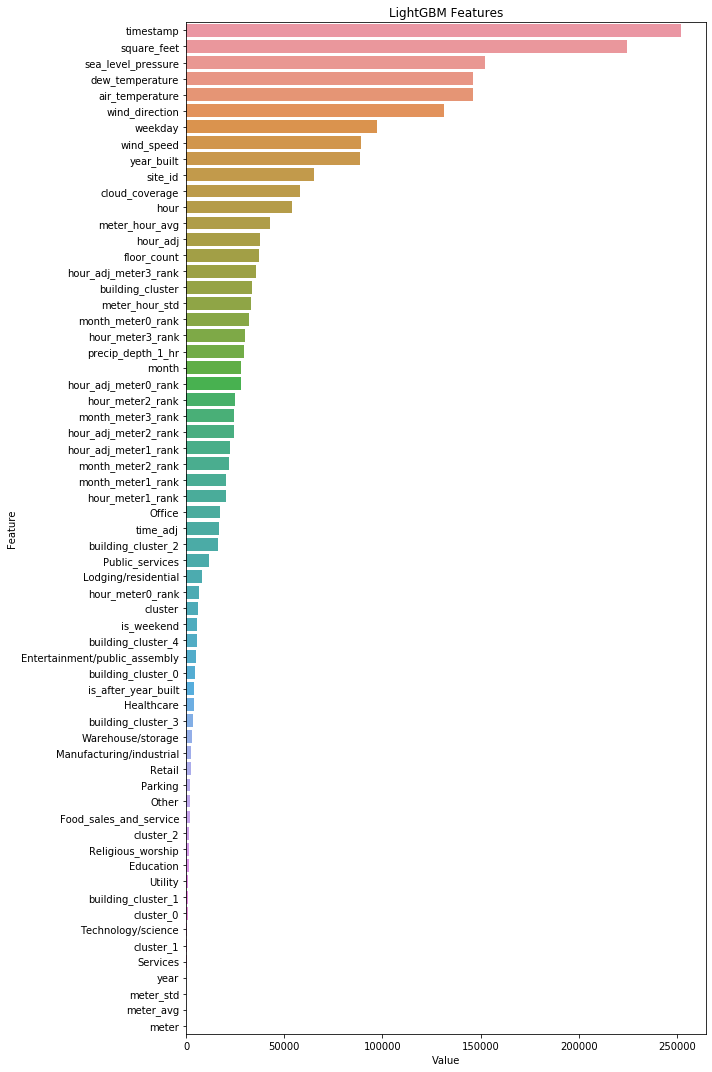

RMSLE:  0.09841460460165642
building model for meter  1


C:\Users\td073\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\td073\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 3500 rounds
[50]	training's rmse: 1.14038	valid_1's rmse: 1.13995
[100]	training's rmse: 0.937841	valid_1's rmse: 0.93951
[150]	training's rmse: 0.863881	valid_1's rmse: 0.867053
[200]	training's rmse: 0.81923	valid_1's rmse: 0.824126
[250]	training's rmse: 0.787644	valid_1's rmse: 0.794601
[300]	training's rmse: 0.761207	valid_1's rmse: 0.769892
[350]	training's rmse: 0.741003	valid_1's rmse: 0.751411
[400]	training's rmse: 0.722907	valid_1's rmse: 0.735181
[450]	training's rmse: 0.710519	valid_1's rmse: 0.724296
[500]	training's rmse: 0.696315	valid_1's rmse: 0.711888
[550]	training's rmse: 0.685267	valid_1's rmse: 0.702389
[600]	training's rmse: 0.674712	valid_1's rmse: 0.693478
[650]	training's rmse: 0.66585	valid_1's rmse: 0.68618
[700]	training's rmse: 0.65775	valid_1's rmse: 0.679638
[750]	training's rmse: 0.650448	valid_1's rmse: 0.673817
[800]	training's rmse: 0.64249	valid_1's rmse: 0.66723
[850]	training's rmse: 0.635828	val

[7150]	training's rmse: 0.429048	valid_1's rmse: 0.571143
[7200]	training's rmse: 0.428393	valid_1's rmse: 0.571114
[7250]	training's rmse: 0.42773	valid_1's rmse: 0.571214
[7300]	training's rmse: 0.427145	valid_1's rmse: 0.571286
[7350]	training's rmse: 0.426496	valid_1's rmse: 0.571315
[7400]	training's rmse: 0.425928	valid_1's rmse: 0.571274
[7450]	training's rmse: 0.425308	valid_1's rmse: 0.571184
[7500]	training's rmse: 0.424768	valid_1's rmse: 0.571228
[7550]	training's rmse: 0.424075	valid_1's rmse: 0.571179
[7600]	training's rmse: 0.423452	valid_1's rmse: 0.571177
[7650]	training's rmse: 0.422863	valid_1's rmse: 0.571194
[7700]	training's rmse: 0.42228	valid_1's rmse: 0.571264
[7750]	training's rmse: 0.42169	valid_1's rmse: 0.571289
[7800]	training's rmse: 0.42114	valid_1's rmse: 0.571317
[7850]	training's rmse: 0.420561	valid_1's rmse: 0.571381
[7900]	training's rmse: 0.419979	valid_1's rmse: 0.571347
[7950]	training's rmse: 0.419386	valid_1's rmse: 0.57131
[8000]	training's r

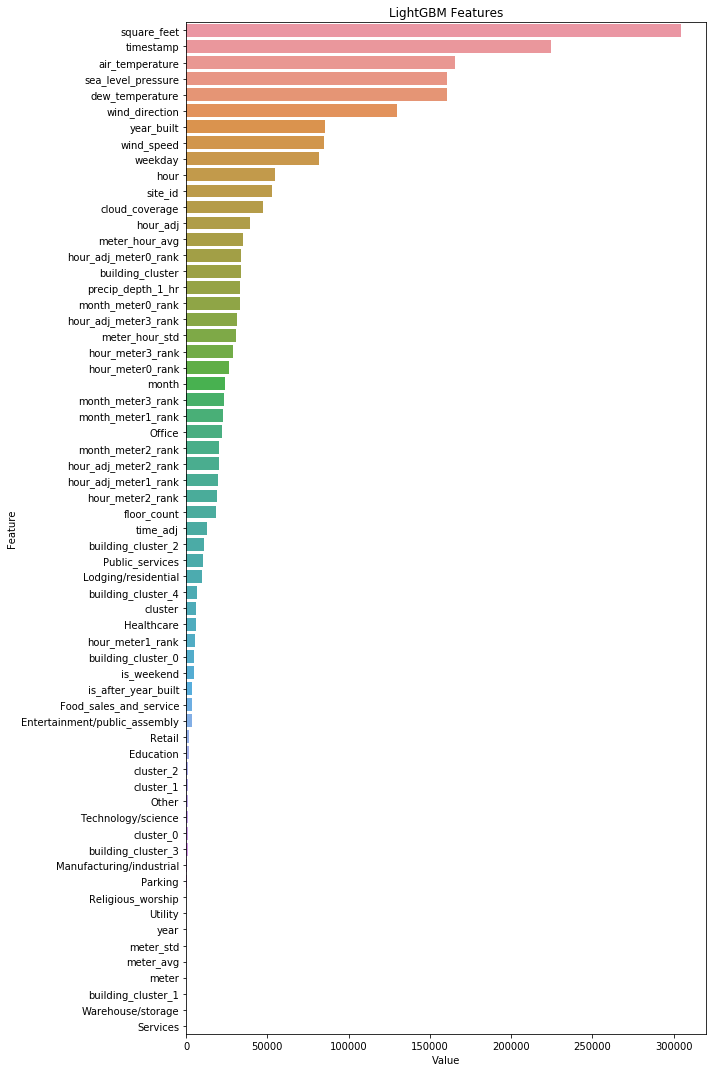

RMSLE:  0.21057847521909878
building model for meter  2


C:\Users\td073\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\td073\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 3500 rounds
[50]	training's rmse: 1.14106	valid_1's rmse: 1.13859
[100]	training's rmse: 0.987184	valid_1's rmse: 0.987117
[150]	training's rmse: 0.940703	valid_1's rmse: 0.944505
[200]	training's rmse: 0.914048	valid_1's rmse: 0.921488
[250]	training's rmse: 0.890942	valid_1's rmse: 0.902129
[300]	training's rmse: 0.875601	valid_1's rmse: 0.890022
[350]	training's rmse: 0.862136	valid_1's rmse: 0.880014
[400]	training's rmse: 0.849389	valid_1's rmse: 0.870724
[450]	training's rmse: 0.839143	valid_1's rmse: 0.863882
[500]	training's rmse: 0.831048	valid_1's rmse: 0.858673
[550]	training's rmse: 0.822816	valid_1's rmse: 0.85328
[600]	training's rmse: 0.815624	valid_1's rmse: 0.84915
[650]	training's rmse: 0.808214	valid_1's rmse: 0.844934
[700]	training's rmse: 0.801082	valid_1's rmse: 0.840996
[750]	training's rmse: 0.795489	valid_1's rmse: 0.838329
[800]	training's rmse: 0.790448	valid_1's rmse: 0.836084
[850]	training's rmse: 0.78509

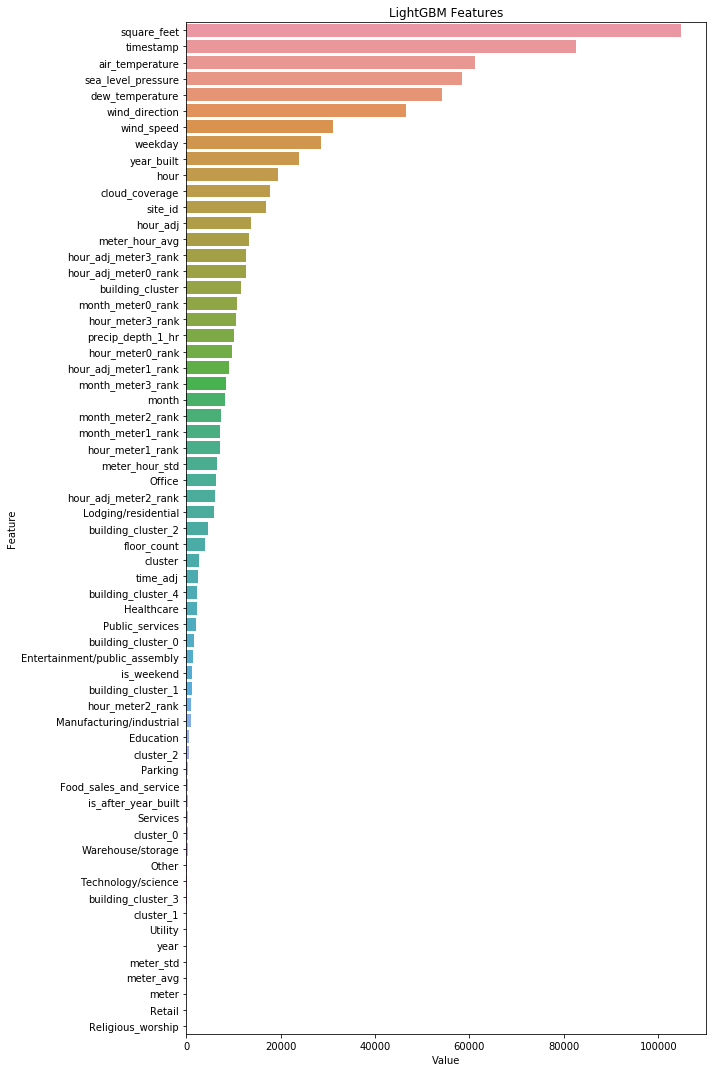

RMSLE:  0.2985419759471981
building model for meter  3


C:\Users\td073\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\td073\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 3500 rounds
[50]	training's rmse: 1.11564	valid_1's rmse: 1.1219
[100]	training's rmse: 1.03149	valid_1's rmse: 1.04891
[150]	training's rmse: 0.99247	valid_1's rmse: 1.01946
[200]	training's rmse: 0.965217	valid_1's rmse: 1.00168
[250]	training's rmse: 0.941777	valid_1's rmse: 0.986167
[300]	training's rmse: 0.923609	valid_1's rmse: 0.976087
[350]	training's rmse: 0.907058	valid_1's rmse: 0.967236
[400]	training's rmse: 0.8935	valid_1's rmse: 0.961316
[450]	training's rmse: 0.881024	valid_1's rmse: 0.955657
[500]	training's rmse: 0.86998	valid_1's rmse: 0.951833
[550]	training's rmse: 0.858562	valid_1's rmse: 0.9476
[600]	training's rmse: 0.849511	valid_1's rmse: 0.94456
[650]	training's rmse: 0.840557	valid_1's rmse: 0.941993
[700]	training's rmse: 0.831909	valid_1's rmse: 0.939513
[750]	training's rmse: 0.823792	valid_1's rmse: 0.937321
[800]	training's rmse: 0.816388	valid_1's rmse: 0.935578
[850]	training's rmse: 0.809227	valid_1'

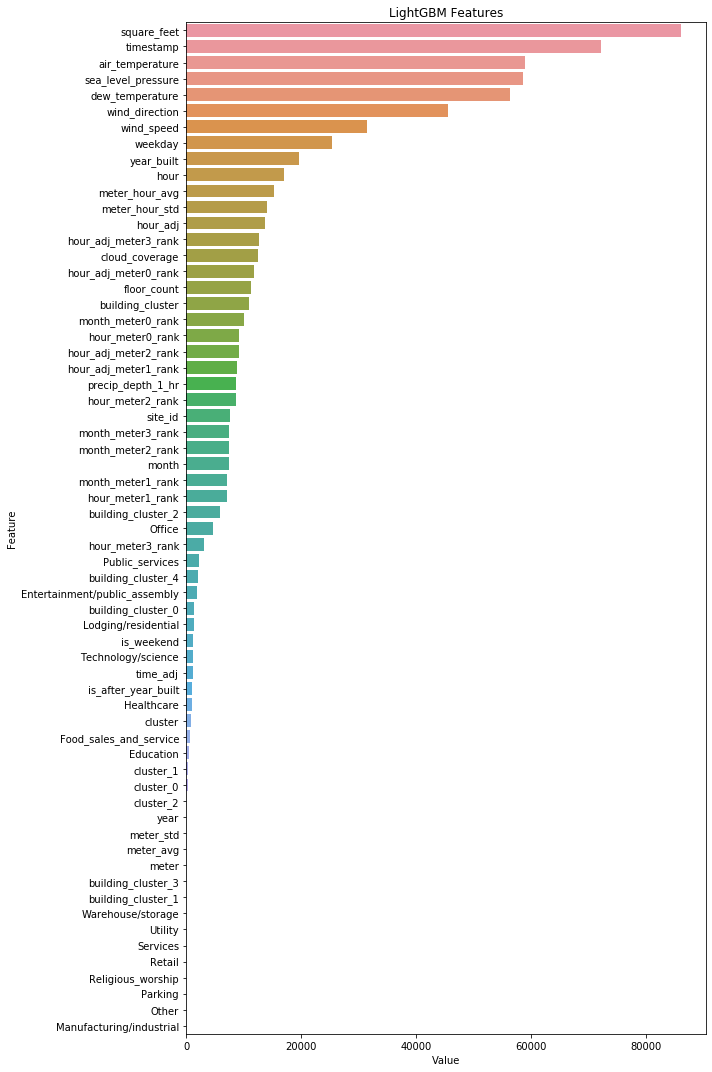

RMSLE:  0.3349000298168387


,meter_type,rmsle
0,0,0.098415
1,1,0.210578
2,2,0.298542
3,3,0.334900


In [107]:
meter_type = [0, 1, 2, 3]
y_val_rmsle = []
#

for i, meter_type in enumerate(meter_type):
    print('building model for meter ', meter_type)
    lgb_train = lgb.Dataset(X_train.loc[X_train.meter == meter_type ,], y_train.loc[y_train.meter == meter_type ,'meter_reading'])
    lgb_eval = lgb.Dataset(X_val.loc[X_val.meter == meter_type ,], y_val.loc[y_val.meter == meter_type ,'meter_reading'])
    gbm = lgb.train(
               lgb_params,
               lgb_train,
               num_boost_round=5000,
               valid_sets=(lgb_train, lgb_eval),
               verbose_eval = 50
               )

    feature_imp = pd.DataFrame(sorted(zip(gbm.feature_importance(), gbm.feature_name()),reverse = True), columns=['Value','Feature'])
    plt.figure(figsize=(10, 15))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
    plt.title('LightGBM Features')
    plt.tight_layout()
    plt.show()

    y_pred = gbm.predict(X_val.loc[X_val.meter == meter_type ,], num_iteration=gbm.best_iteration)
    fix_predictions(y_pred)
    rmsle = np.sqrt(mean_squared_log_error(y_pred, (y_val.loc[y_val.meter == meter_type ,'meter_reading'])))
    print('RMSLE: ', rmsle)
    
    y_val_rmsle.append(rmsle)

    gbm.save_model('E:/data/Kaggle Energy Prediction/saved models/lgb_classifier_{}_{}_{}_log.txt'.format(datetime.now().strftime("%d-%m-%Y"), rmsle, meter_type), num_iteration=gbm.best_iteration)

    
testing_result = pd.DataFrame({'meter_type':[0,1,2,3], 'rmsle':y_val_rmsle})
testing_result

#### Base model with log(1+p) transform on target

In [3]:
# load data
X_train = pd.read_csv('E:/data/Kaggle Energy Prediction/train_cleaned_part2_X_train.csv')
X_val = pd.read_csv('E:/data/Kaggle Energy Prediction/train_cleaned_part2_X_val.csv')
y_train = pd.read_csv('E:/data/Kaggle Energy Prediction/train_cleaned_part2_y_train.csv')
y_val = pd.read_csv('E:/data/Kaggle Energy Prediction/train_cleaned_part2_y_val.csv')

In [6]:
del X_train['Unnamed: 0']
del X_val['Unnamed: 0']
del y_train['Unnamed: 0']
del y_val['Unnamed: 0']

In [7]:
X_train = reduce_mem_usage(X_train)
X_val = reduce_mem_usage(X_val)
y_train = reduce_mem_usage(y_train)
y_val = reduce_mem_usage(y_val)

Mem. usage decreased to 1388.13 Mb (80.6% reduction)
Mem. usage decreased to 347.03 Mb (80.6% reduction)
Mem. usage decreased to 77.12 Mb (68.7% reduction)
Mem. usage decreased to 19.28 Mb (68.7% reduction)


In [8]:
# transform target to log(1+p)
y_train['meter_reading'] = np.log1p(y_train['meter_reading'])
y_val['meter_reading'] = np.log1p(y_val['meter_reading'])
y_train.head()

,meter,meter_reading
0,0,5.019133
1,0,3.507058
2,0,2.865623
3,2,7.690972
4,1,4.843052


In [9]:
 lgb_params = {
                   'objective':'regression',
                   'boosting_type':'gbdt',
                   'metric':'rmse',
                   'n_jobs':-1,
                   'learning_rate':0.07,
                   'num_leaves': 2**8,
                   'max_depth':-1,
                   'tree_learner':'serial',
                   'colsample_bytree': 0.7,
                   'subsample_freq':1,
                   'subsample':0.5,
                   'n_estimators':8500,
                   'max_bin':255,
                   'verbose':1,
                   'seed': 2,
                   'early_stopping_rounds':3500, 
                    #'device' : 'gpu'
               } 

In [10]:
gc.collect()

92

building model for meter  0


C:\Users\td073\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\td073\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 3500 rounds
[50]	training's rmse: 0.608083	valid_1's rmse: 0.60747
[100]	training's rmse: 0.48894	valid_1's rmse: 0.4888
[150]	training's rmse: 0.442487	valid_1's rmse: 0.442766
[200]	training's rmse: 0.418124	valid_1's rmse: 0.418807
[250]	training's rmse: 0.399888	valid_1's rmse: 0.400878
[300]	training's rmse: 0.387182	valid_1's rmse: 0.388579
[350]	training's rmse: 0.377317	valid_1's rmse: 0.379168
[400]	training's rmse: 0.369113	valid_1's rmse: 0.371349
[450]	training's rmse: 0.362501	valid_1's rmse: 0.365145
[500]	training's rmse: 0.356503	valid_1's rmse: 0.359512
[550]	training's rmse: 0.350121	valid_1's rmse: 0.353536
[600]	training's rmse: 0.345564	valid_1's rmse: 0.349363
[650]	training's rmse: 0.340678	valid_1's rmse: 0.344844
[700]	training's rmse: 0.336389	valid_1's rmse: 0.34085
[750]	training's rmse: 0.332807	valid_1's rmse: 0.3376
[800]	training's rmse: 0.32882	valid_1's rmse: 0.333996
[850]	training's rmse: 0.325266	va

[7150]	training's rmse: 0.250115	valid_1's rmse: 0.282535
[7200]	training's rmse: 0.249905	valid_1's rmse: 0.282488
[7250]	training's rmse: 0.249767	valid_1's rmse: 0.282489
[7300]	training's rmse: 0.249628	valid_1's rmse: 0.282491
[7350]	training's rmse: 0.249496	valid_1's rmse: 0.282486
[7400]	training's rmse: 0.249343	valid_1's rmse: 0.282462
[7450]	training's rmse: 0.249208	valid_1's rmse: 0.282461
[7500]	training's rmse: 0.249069	valid_1's rmse: 0.282466
[7550]	training's rmse: 0.248914	valid_1's rmse: 0.282427
[7600]	training's rmse: 0.248752	valid_1's rmse: 0.282403
[7650]	training's rmse: 0.248611	valid_1's rmse: 0.28239
[7700]	training's rmse: 0.248439	valid_1's rmse: 0.282331
[7750]	training's rmse: 0.248296	valid_1's rmse: 0.28231
[7800]	training's rmse: 0.248136	valid_1's rmse: 0.282287
[7850]	training's rmse: 0.247999	valid_1's rmse: 0.282277
[7900]	training's rmse: 0.247862	valid_1's rmse: 0.282261
[7950]	training's rmse: 0.24771	valid_1's rmse: 0.282274
[8000]	training's

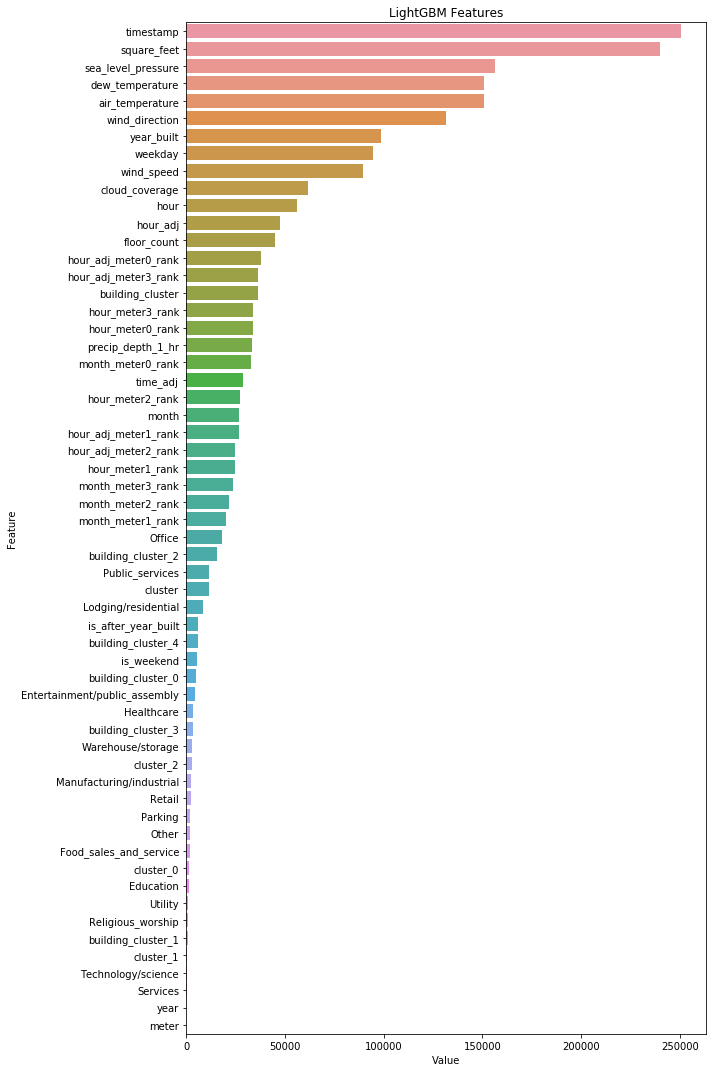

RMSLE:  0.10099904408787407
building model for meter  1


C:\Users\td073\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\td073\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 3500 rounds
[50]	training's rmse: 1.1579	valid_1's rmse: 1.15766
[100]	training's rmse: 0.95091	valid_1's rmse: 0.952997
[150]	training's rmse: 0.873181	valid_1's rmse: 0.877063
[200]	training's rmse: 0.829094	valid_1's rmse: 0.834603
[250]	training's rmse: 0.799319	valid_1's rmse: 0.806419
[300]	training's rmse: 0.774088	valid_1's rmse: 0.782877
[350]	training's rmse: 0.754672	valid_1's rmse: 0.765105
[400]	training's rmse: 0.737961	valid_1's rmse: 0.750202
[450]	training's rmse: 0.724942	valid_1's rmse: 0.738712
[500]	training's rmse: 0.711865	valid_1's rmse: 0.727289
[550]	training's rmse: 0.700118	valid_1's rmse: 0.717154
[600]	training's rmse: 0.689141	valid_1's rmse: 0.707833
[650]	training's rmse: 0.678206	valid_1's rmse: 0.698394
[700]	training's rmse: 0.670057	valid_1's rmse: 0.691865
[750]	training's rmse: 0.663797	valid_1's rmse: 0.686961
[800]	training's rmse: 0.655519	valid_1's rmse: 0.680293
[850]	training's rmse: 0.64930

[7100]	training's rmse: 0.434492	valid_1's rmse: 0.57552
[7150]	training's rmse: 0.433825	valid_1's rmse: 0.575456
[7200]	training's rmse: 0.43316	valid_1's rmse: 0.575406
[7250]	training's rmse: 0.432483	valid_1's rmse: 0.575392
[7300]	training's rmse: 0.431912	valid_1's rmse: 0.575446
[7350]	training's rmse: 0.431309	valid_1's rmse: 0.575403
[7400]	training's rmse: 0.430627	valid_1's rmse: 0.575332
[7450]	training's rmse: 0.430021	valid_1's rmse: 0.575411
[7500]	training's rmse: 0.429367	valid_1's rmse: 0.575487
[7550]	training's rmse: 0.428765	valid_1's rmse: 0.575431
[7600]	training's rmse: 0.428128	valid_1's rmse: 0.575416
[7650]	training's rmse: 0.427431	valid_1's rmse: 0.575348
[7700]	training's rmse: 0.426891	valid_1's rmse: 0.575316
[7750]	training's rmse: 0.426383	valid_1's rmse: 0.575342
[7800]	training's rmse: 0.425815	valid_1's rmse: 0.575377
[7850]	training's rmse: 0.425289	valid_1's rmse: 0.575567
[7900]	training's rmse: 0.424668	valid_1's rmse: 0.575528
[7950]	training'

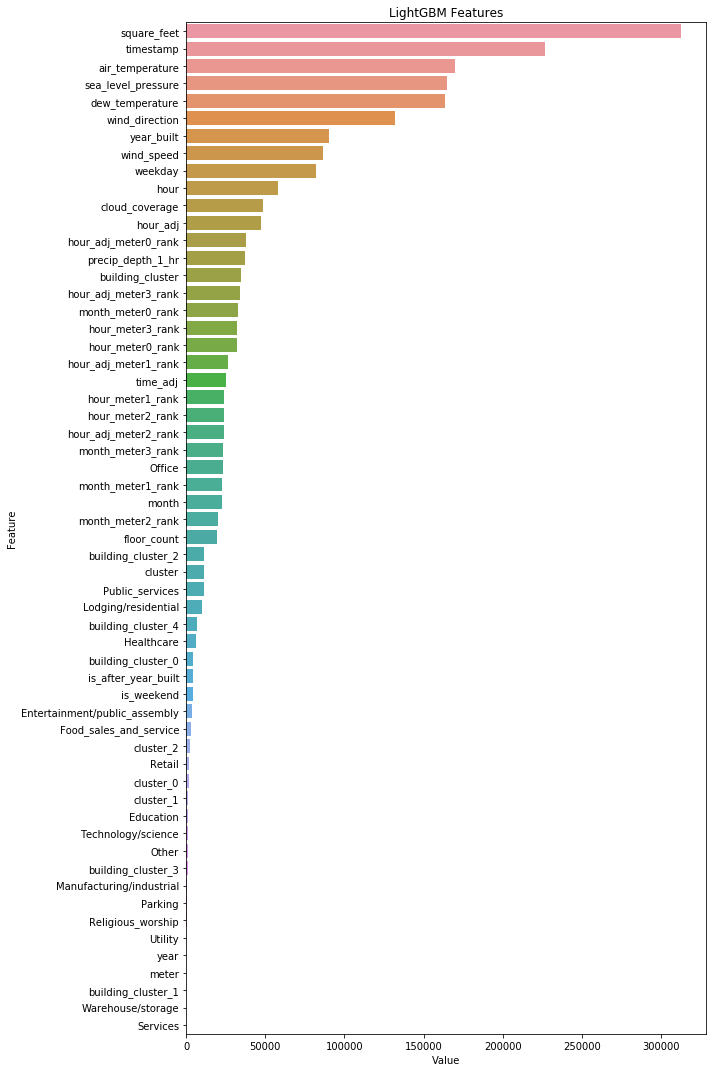

RMSLE:  0.21244750637712598
building model for meter  2


C:\Users\td073\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\td073\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 3500 rounds
[50]	training's rmse: 1.15273	valid_1's rmse: 1.15037
[100]	training's rmse: 0.994221	valid_1's rmse: 0.993921
[150]	training's rmse: 0.943304	valid_1's rmse: 0.946622
[200]	training's rmse: 0.914291	valid_1's rmse: 0.9211
[250]	training's rmse: 0.894026	valid_1's rmse: 0.904579
[300]	training's rmse: 0.877847	valid_1's rmse: 0.891748
[350]	training's rmse: 0.865472	valid_1's rmse: 0.882597
[400]	training's rmse: 0.853111	valid_1's rmse: 0.873805
[450]	training's rmse: 0.843744	valid_1's rmse: 0.867399
[500]	training's rmse: 0.835214	valid_1's rmse: 0.861995
[550]	training's rmse: 0.827358	valid_1's rmse: 0.857083
[600]	training's rmse: 0.818993	valid_1's rmse: 0.851718
[650]	training's rmse: 0.812126	valid_1's rmse: 0.847964
[700]	training's rmse: 0.805789	valid_1's rmse: 0.844404
[750]	training's rmse: 0.799522	valid_1's rmse: 0.840901
[800]	training's rmse: 0.794242	valid_1's rmse: 0.838579
[850]	training's rmse: 0.78967

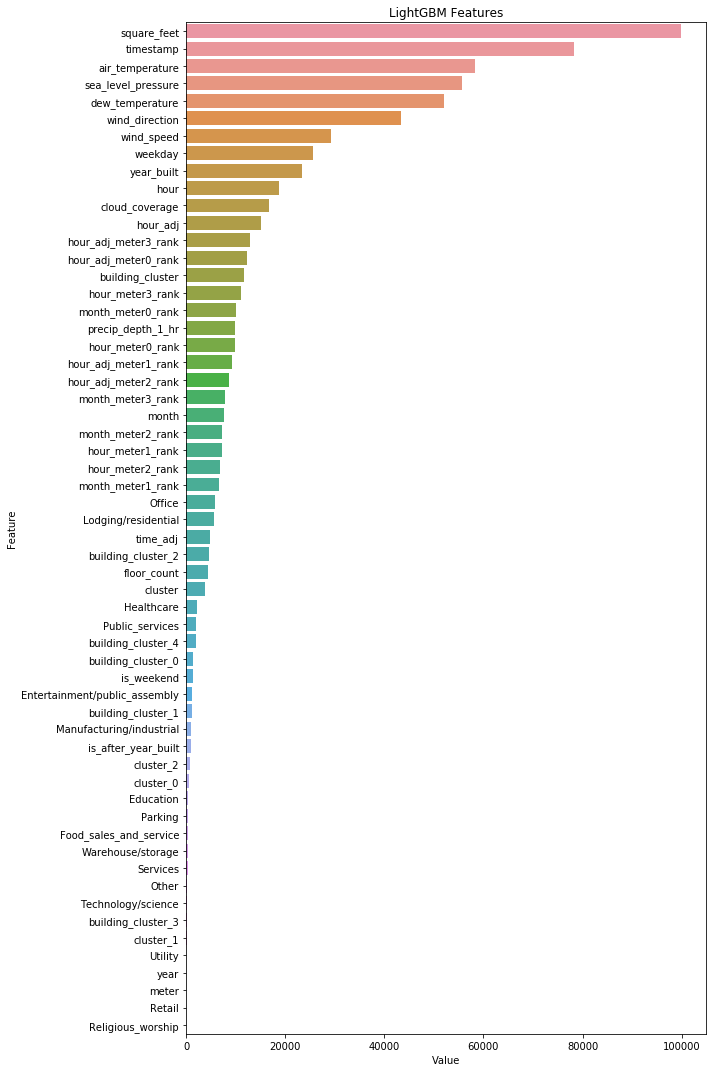

RMSLE:  0.299544467958887
building model for meter  3


C:\Users\td073\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\td073\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 3500 rounds
[50]	training's rmse: 1.13156	valid_1's rmse: 1.13794
[100]	training's rmse: 1.03569	valid_1's rmse: 1.05178
[150]	training's rmse: 0.993884	valid_1's rmse: 1.01926
[200]	training's rmse: 0.964818	valid_1's rmse: 0.999618
[250]	training's rmse: 0.944111	valid_1's rmse: 0.987015
[300]	training's rmse: 0.92835	valid_1's rmse: 0.978698
[350]	training's rmse: 0.911785	valid_1's rmse: 0.969978
[400]	training's rmse: 0.897925	valid_1's rmse: 0.963337
[450]	training's rmse: 0.885678	valid_1's rmse: 0.958089
[500]	training's rmse: 0.874197	valid_1's rmse: 0.953524
[550]	training's rmse: 0.863096	valid_1's rmse: 0.948453
[600]	training's rmse: 0.852991	valid_1's rmse: 0.944497
[650]	training's rmse: 0.84294	valid_1's rmse: 0.941488
[700]	training's rmse: 0.83457	valid_1's rmse: 0.938989
[750]	training's rmse: 0.827204	valid_1's rmse: 0.937215
[800]	training's rmse: 0.81962	valid_1's rmse: 0.935131
[850]	training's rmse: 0.812615	val

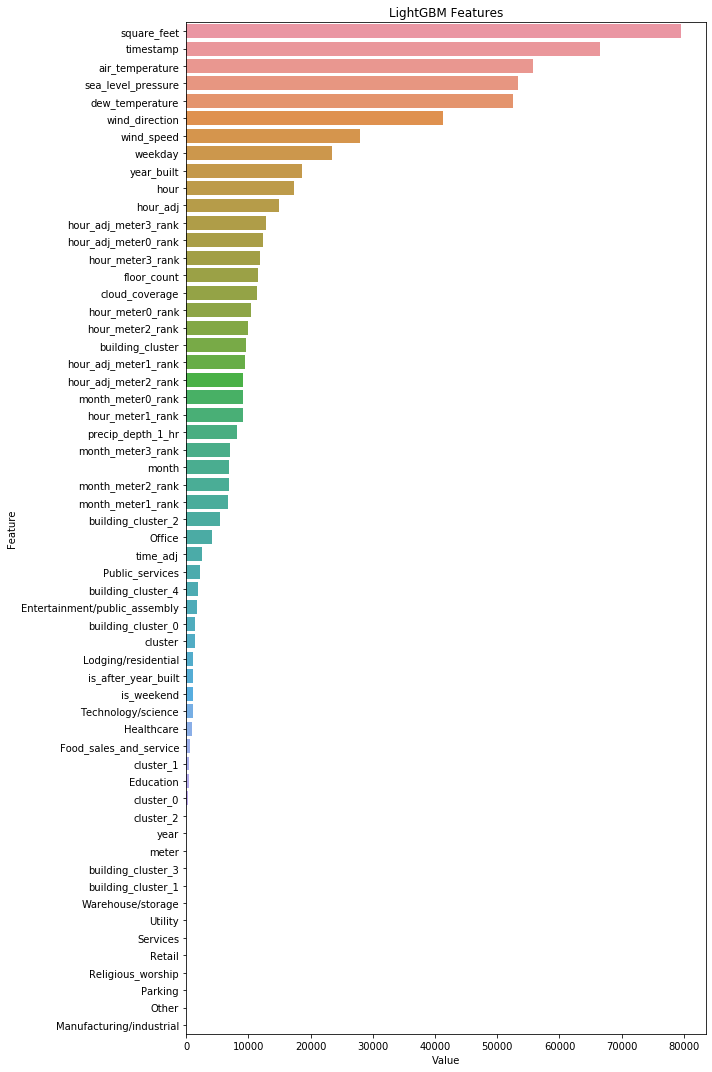

RMSLE:  0.33499459475653287


,meter_type,rmsle
0,0,0.100999
1,1,0.212448
2,2,0.299544
3,3,0.334995


In [11]:
meter_type = [0, 1, 2, 3]
y_val_rmsle = []
#

for i, meter_type in enumerate(meter_type):
    print('building model for meter ', meter_type)
    lgb_train = lgb.Dataset(X_train.loc[X_train.meter == meter_type ,], y_train.loc[y_train.meter == meter_type ,'meter_reading'])
    lgb_eval = lgb.Dataset(X_val.loc[X_val.meter == meter_type ,], y_val.loc[y_val.meter == meter_type ,'meter_reading'])
    gbm = lgb.train(
               lgb_params,
               lgb_train,
               num_boost_round=5000,
               valid_sets=(lgb_train, lgb_eval),
               verbose_eval = 50
               ) 
    
    feature_imp = pd.DataFrame(sorted(zip(gbm.feature_importance(), gbm.feature_name()),reverse = True), columns=['Value','Feature'])
    plt.figure(figsize=(10, 15))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
    plt.title('LightGBM Features')
    plt.tight_layout()
    plt.show()

    y_pred = gbm.predict(X_val.loc[X_val.meter == meter_type ,], num_iteration=gbm.best_iteration)
    fix_predictions(y_pred)
    rmsle = np.sqrt(mean_squared_log_error(y_pred, (y_val.loc[y_val.meter == meter_type ,'meter_reading'])))
    print('RMSLE: ', rmsle)
    
    y_val_rmsle.append(rmsle)

    gbm.save_model('E:/data/Kaggle Energy Prediction/saved models/lgb_classifier_{}_{}_{}_log.txt'.format(datetime.now().strftime("%d-%m-%Y"), rmsle, meter_type), num_iteration=gbm.best_iteration)

    
testing_result = pd.DataFrame({'meter_type':[0,1,2,3], 'rmsle':y_val_rmsle})
testing_result

#### Try with lower learning rate

In [119]:
 lgb_params = {
                   'objective':'regression',
                   'boosting_type':'gbdt',
                   'metric':'rmse',
                   'n_jobs':-1,
                   'learning_rate':0.003,
                   'num_leaves': 2**8,
                   'max_depth':-1,
                   'tree_learner':'serial',
                   'colsample_bytree': 0.7,
                   'subsample_freq':1,
                   'subsample':0.5,
                   'n_estimators':8500,
                   'max_bin':255,
                   'verbose':1,
                   'seed': 2,
                   'early_stopping_rounds':3500, 
                    #'device' : 'gpu'
               } 

building model for meter  0


C:\Users\td073\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 3500 rounds
[50]	training's rmse: 1.54289	valid_1's rmse: 1.54319
[100]	training's rmse: 1.40156	valid_1's rmse: 1.40169
[150]	training's rmse: 1.28365	valid_1's rmse: 1.28363
[200]	training's rmse: 1.18631	valid_1's rmse: 1.18617
[250]	training's rmse: 1.10791	valid_1's rmse: 1.10767
[300]	training's rmse: 1.03895	valid_1's rmse: 1.03862
[350]	training's rmse: 0.978169	valid_1's rmse: 0.977755
[400]	training's rmse: 0.928714	valid_1's rmse: 0.928247
[450]	training's rmse: 0.887536	valid_1's rmse: 0.887029
[500]	training's rmse: 0.84925	valid_1's rmse: 0.848701
[550]	training's rmse: 0.818224	valid_1's rmse: 0.817641
[600]	training's rmse: 0.788261	valid_1's rmse: 0.787639
[650]	training's rmse: 0.761483	valid_1's rmse: 0.760836
[700]	training's rmse: 0.739902	valid_1's rmse: 0.739225
[750]	training's rmse: 0.720395	valid_1's rmse: 0.719704
[800]	training's rmse: 0.701749	valid_1's rmse: 0.70107
[850]	training's rmse: 0.68596	valid_1's

[7150]	training's rmse: 0.381217	valid_1's rmse: 0.382698
[7200]	training's rmse: 0.380821	valid_1's rmse: 0.382322
[7250]	training's rmse: 0.380399	valid_1's rmse: 0.381915
[7300]	training's rmse: 0.379948	valid_1's rmse: 0.381477
[7350]	training's rmse: 0.379504	valid_1's rmse: 0.38105
[7400]	training's rmse: 0.379015	valid_1's rmse: 0.380579
[7450]	training's rmse: 0.378533	valid_1's rmse: 0.380119
[7500]	training's rmse: 0.37806	valid_1's rmse: 0.379667
[7550]	training's rmse: 0.377622	valid_1's rmse: 0.379243
[7600]	training's rmse: 0.37721	valid_1's rmse: 0.378849
[7650]	training's rmse: 0.376782	valid_1's rmse: 0.378434
[7700]	training's rmse: 0.376382	valid_1's rmse: 0.378049
[7750]	training's rmse: 0.375938	valid_1's rmse: 0.377625
[7800]	training's rmse: 0.37552	valid_1's rmse: 0.377223
[7850]	training's rmse: 0.375058	valid_1's rmse: 0.376784
[7900]	training's rmse: 0.374678	valid_1's rmse: 0.376419
[7950]	training's rmse: 0.374323	valid_1's rmse: 0.37608
[8000]	training's r

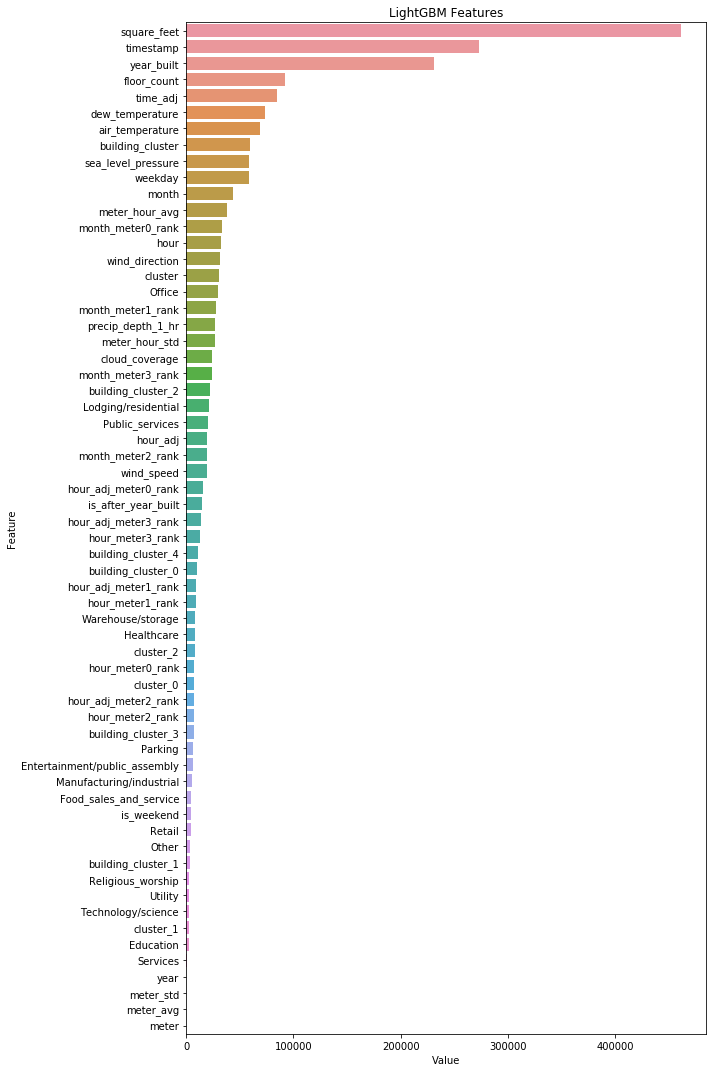

RMSLE:  0.13056096236903422
building model for meter  1


C:\Users\td073\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\td073\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 3500 rounds
[50]	training's rmse: 2.34876	valid_1's rmse: 2.34804
[100]	training's rmse: 2.19222	valid_1's rmse: 2.19144
[150]	training's rmse: 2.05393	valid_1's rmse: 2.05307
[200]	training's rmse: 1.93795	valid_1's rmse: 1.93696
[250]	training's rmse: 1.83891	valid_1's rmse: 1.83781
[300]	training's rmse: 1.75742	valid_1's rmse: 1.75626
[350]	training's rmse: 1.68304	valid_1's rmse: 1.68178
[400]	training's rmse: 1.61889	valid_1's rmse: 1.61759
[450]	training's rmse: 1.56444	valid_1's rmse: 1.56309
[500]	training's rmse: 1.51356	valid_1's rmse: 1.51219
[550]	training's rmse: 1.46799	valid_1's rmse: 1.46658
[600]	training's rmse: 1.42771	valid_1's rmse: 1.4263
[650]	training's rmse: 1.39082	valid_1's rmse: 1.38939
[700]	training's rmse: 1.36231	valid_1's rmse: 1.36089
[750]	training's rmse: 1.33222	valid_1's rmse: 1.33082
[800]	training's rmse: 1.30462	valid_1's rmse: 1.30328
[850]	training's rmse: 1.28087	valid_1's rmse: 1.27958
[900

[7200]	training's rmse: 0.762126	valid_1's rmse: 0.771483
[7250]	training's rmse: 0.761156	valid_1's rmse: 0.770585
[7300]	training's rmse: 0.760127	valid_1's rmse: 0.769632
[7350]	training's rmse: 0.759115	valid_1's rmse: 0.768693
[7400]	training's rmse: 0.75828	valid_1's rmse: 0.767928
[7450]	training's rmse: 0.757386	valid_1's rmse: 0.767112
[7500]	training's rmse: 0.75643	valid_1's rmse: 0.766232
[7550]	training's rmse: 0.755528	valid_1's rmse: 0.765404
[7600]	training's rmse: 0.754672	valid_1's rmse: 0.76462
[7650]	training's rmse: 0.753857	valid_1's rmse: 0.763875
[7700]	training's rmse: 0.752935	valid_1's rmse: 0.763019
[7750]	training's rmse: 0.752075	valid_1's rmse: 0.762233
[7800]	training's rmse: 0.751212	valid_1's rmse: 0.761436
[7850]	training's rmse: 0.750363	valid_1's rmse: 0.760652
[7900]	training's rmse: 0.749382	valid_1's rmse: 0.759742
[7950]	training's rmse: 0.74859	valid_1's rmse: 0.759025
[8000]	training's rmse: 0.747686	valid_1's rmse: 0.7582
[8050]	training's rm

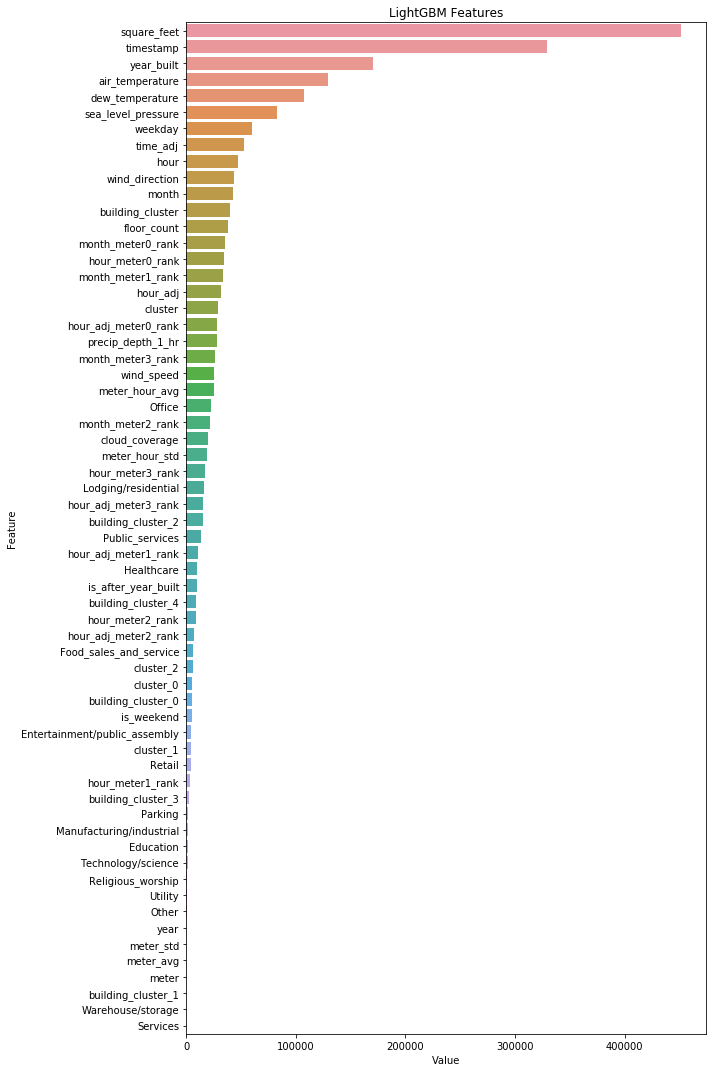

RMSLE:  0.28840749983551517
building model for meter  2


C:\Users\td073\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\td073\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 3500 rounds
[50]	training's rmse: 2.43855	valid_1's rmse: 2.43377
[100]	training's rmse: 2.27277	valid_1's rmse: 2.26849
[150]	training's rmse: 2.1058	valid_1's rmse: 2.10209
[200]	training's rmse: 1.97435	valid_1's rmse: 1.97104
[250]	training's rmse: 1.86404	valid_1's rmse: 1.86105
[300]	training's rmse: 1.76729	valid_1's rmse: 1.76453
[350]	training's rmse: 1.68707	valid_1's rmse: 1.68455
[400]	training's rmse: 1.61625	valid_1's rmse: 1.61391
[450]	training's rmse: 1.55706	valid_1's rmse: 1.55481
[500]	training's rmse: 1.50098	valid_1's rmse: 1.49878
[550]	training's rmse: 1.45361	valid_1's rmse: 1.45145
[600]	training's rmse: 1.41404	valid_1's rmse: 1.41188
[650]	training's rmse: 1.37795	valid_1's rmse: 1.37583
[700]	training's rmse: 1.34353	valid_1's rmse: 1.34143
[750]	training's rmse: 1.31025	valid_1's rmse: 1.30816
[800]	training's rmse: 1.28373	valid_1's rmse: 1.28162
[850]	training's rmse: 1.25811	valid_1's rmse: 1.25598
[900

[7200]	training's rmse: 0.868505	valid_1's rmse: 0.882954
[7250]	training's rmse: 0.867912	valid_1's rmse: 0.8825
[7300]	training's rmse: 0.867207	valid_1's rmse: 0.881945
[7350]	training's rmse: 0.8666	valid_1's rmse: 0.881493
[7400]	training's rmse: 0.86593	valid_1's rmse: 0.88098
[7450]	training's rmse: 0.865323	valid_1's rmse: 0.880515
[7500]	training's rmse: 0.864736	valid_1's rmse: 0.880068
[7550]	training's rmse: 0.864171	valid_1's rmse: 0.879634
[7600]	training's rmse: 0.863505	valid_1's rmse: 0.879111
[7650]	training's rmse: 0.862973	valid_1's rmse: 0.878715
[7700]	training's rmse: 0.862389	valid_1's rmse: 0.878265
[7750]	training's rmse: 0.861843	valid_1's rmse: 0.877858
[7800]	training's rmse: 0.861251	valid_1's rmse: 0.877407
[7850]	training's rmse: 0.86065	valid_1's rmse: 0.87695
[7900]	training's rmse: 0.860106	valid_1's rmse: 0.876545
[7950]	training's rmse: 0.859517	valid_1's rmse: 0.876093
[8000]	training's rmse: 0.858948	valid_1's rmse: 0.87566
[8050]	training's rmse:

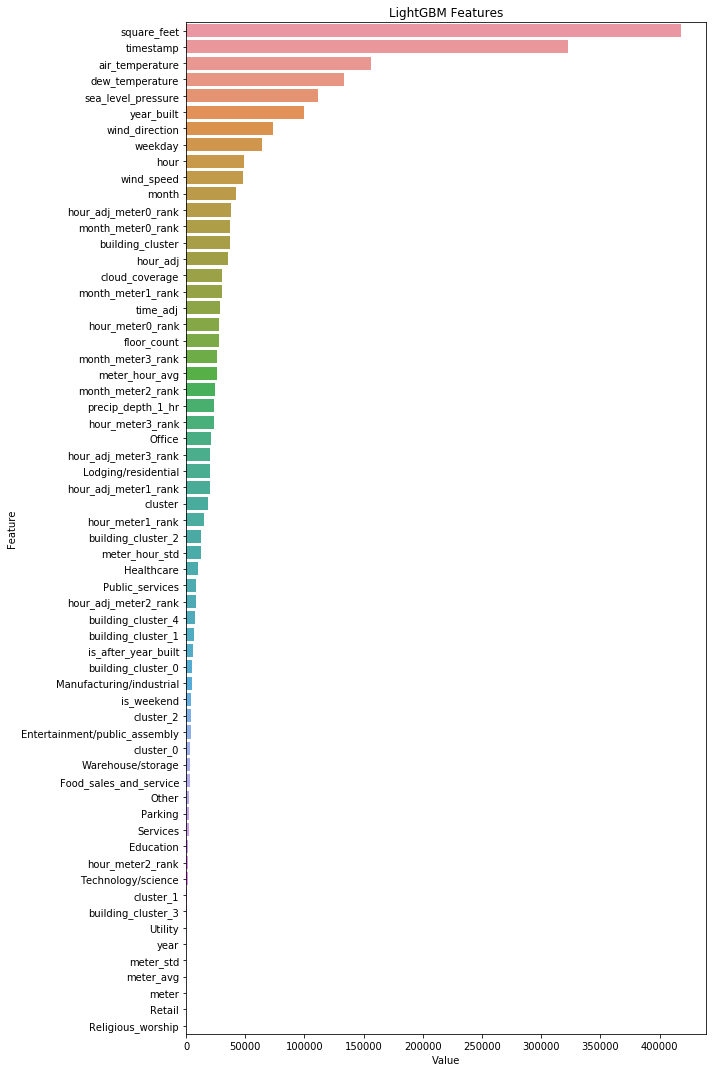

RMSLE:  0.32393692242919403
building model for meter  3


C:\Users\td073\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\td073\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 3500 rounds
[50]	training's rmse: 2.3799	valid_1's rmse: 2.37754
[100]	training's rmse: 2.18763	valid_1's rmse: 2.18589
[150]	training's rmse: 2.01465	valid_1's rmse: 2.01344
[200]	training's rmse: 1.87454	valid_1's rmse: 1.87386
[250]	training's rmse: 1.76067	valid_1's rmse: 1.76048
[300]	training's rmse: 1.65769	valid_1's rmse: 1.6579
[350]	training's rmse: 1.5708	valid_1's rmse: 1.5714
[400]	training's rmse: 1.49967	valid_1's rmse: 1.50067
[450]	training's rmse: 1.44405	valid_1's rmse: 1.44544
[500]	training's rmse: 1.39498	valid_1's rmse: 1.3967
[550]	training's rmse: 1.35365	valid_1's rmse: 1.35571
[600]	training's rmse: 1.31732	valid_1's rmse: 1.31969
[650]	training's rmse: 1.28945	valid_1's rmse: 1.29222
[700]	training's rmse: 1.26288	valid_1's rmse: 1.26593
[750]	training's rmse: 1.23884	valid_1's rmse: 1.2422
[800]	training's rmse: 1.21808	valid_1's rmse: 1.22175
[850]	training's rmse: 1.20147	valid_1's rmse: 1.20551
[900]	tra

[7250]	training's rmse: 0.914708	valid_1's rmse: 0.967902
[7300]	training's rmse: 0.913964	valid_1's rmse: 0.967502
[7350]	training's rmse: 0.913249	valid_1's rmse: 0.967095
[7400]	training's rmse: 0.912544	valid_1's rmse: 0.966714
[7450]	training's rmse: 0.911811	valid_1's rmse: 0.966327
[7500]	training's rmse: 0.911186	valid_1's rmse: 0.966017
[7550]	training's rmse: 0.910478	valid_1's rmse: 0.965643
[7600]	training's rmse: 0.909801	valid_1's rmse: 0.965278
[7650]	training's rmse: 0.909097	valid_1's rmse: 0.9649
[7700]	training's rmse: 0.908378	valid_1's rmse: 0.964494
[7750]	training's rmse: 0.907694	valid_1's rmse: 0.964147
[7800]	training's rmse: 0.907063	valid_1's rmse: 0.963835
[7850]	training's rmse: 0.906428	valid_1's rmse: 0.963509
[7900]	training's rmse: 0.905737	valid_1's rmse: 0.963181
[7950]	training's rmse: 0.905117	valid_1's rmse: 0.962889
[8000]	training's rmse: 0.904452	valid_1's rmse: 0.962551
[8050]	training's rmse: 0.903736	valid_1's rmse: 0.962154
[8100]	training'

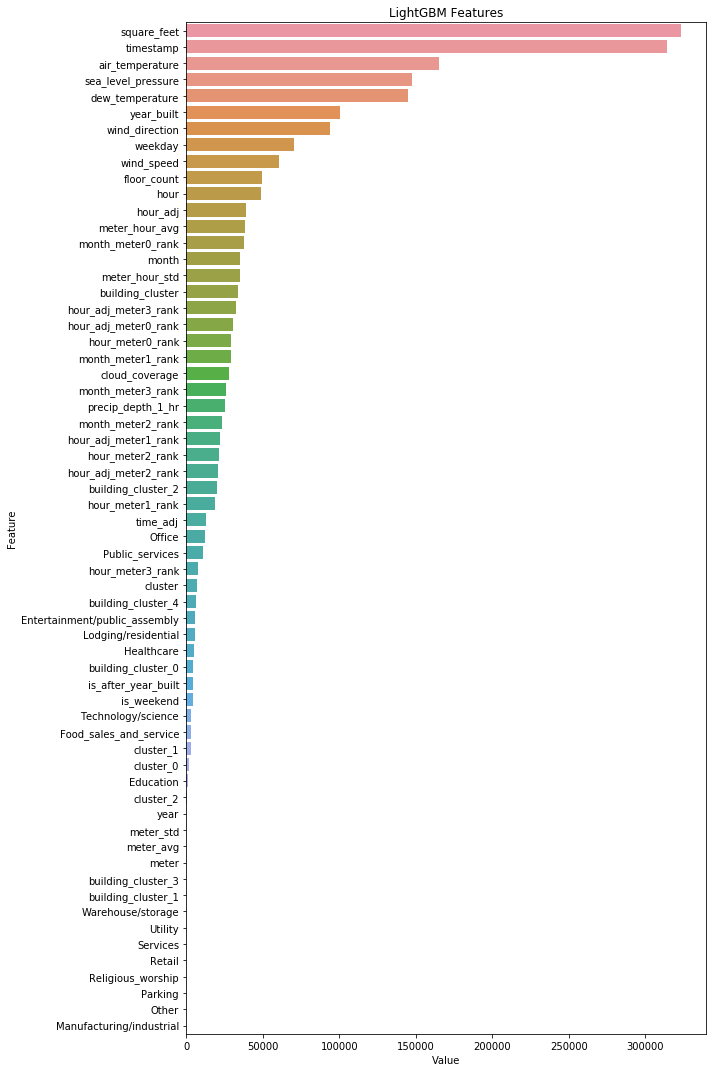

RMSLE:  0.3595650255480438


,meter_type,rmsle
0,0,0.130561
1,1,0.288407
2,2,0.323937
3,3,0.359565


In [120]:
meter_type = [0, 1, 2, 3]
y_val_rmsle = []
#

for i, meter_type in enumerate(meter_type):
    print('building model for meter ', meter_type)
    lgb_train = lgb.Dataset(X_train.loc[X_train.meter == meter_type ,], y_train.loc[y_train.meter == meter_type ,'meter_reading'])
    lgb_eval = lgb.Dataset(X_val.loc[X_val.meter == meter_type ,], y_val.loc[y_val.meter == meter_type ,'meter_reading'])
    gbm = lgb.train(
               lgb_params,
               lgb_train,
               num_boost_round=5000,
               valid_sets=(lgb_train, lgb_eval),
               verbose_eval = 50
               ) 
    
    feature_imp = pd.DataFrame(sorted(zip(gbm.feature_importance(), gbm.feature_name()),reverse = True), columns=['Value','Feature'])
    plt.figure(figsize=(10, 15))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
    plt.title('LightGBM Features')
    plt.tight_layout()
    plt.show()

    y_pred = gbm.predict(X_val.loc[X_val.meter == meter_type ,], num_iteration=gbm.best_iteration)
    fix_predictions(y_pred)
    rmsle = np.sqrt(mean_squared_log_error(y_pred, (y_val.loc[y_val.meter == meter_type ,'meter_reading'])))
    print('RMSLE: ', rmsle)
    
    y_val_rmsle.append(rmsle)

    gbm.save_model('E:/data/Kaggle Energy Prediction/saved models/lgb_classifier_{}_{}_{}_log_low_learning.txt'.format(datetime.now().strftime("%d-%m-%Y"), rmsle, meter_type), num_iteration=gbm.best_iteration)

    
testing_result = pd.DataFrame({'meter_type':[0,1,2,3], 'rmsle':y_val_rmsle})
testing_result

#### Try with large num_leaves

In [14]:
 lgb_params = {
                   'objective':'regression',
                   'boosting_type':'gbdt',
                   'metric':'rmse',
                   'n_jobs':-1,
                   'learning_rate':0.07,
                   'num_leaves': 2**9,
                   'max_depth':-1,
                   'tree_learner':'serial',
                   'colsample_bytree': 0.7,
                   'subsample_freq':1,
                   'subsample':0.5,
                   'n_estimators':8500,
                   'max_bin':255,
                   'verbose':1,
                   'seed': 2,
                   'early_stopping_rounds':3500, 
                    #'device' : 'gpu'
               } 

In [ ]:
meter_type = [0, 1, 2, 3]
y_val_rmsle = []
#

for i, meter_type in enumerate(meter_type):
    print('building model for meter ', meter_type)
    lgb_train = lgb.Dataset(X_train.loc[X_train.meter == meter_type ,], y_train.loc[y_train.meter == meter_type ,'meter_reading'])
    lgb_eval = lgb.Dataset(X_val.loc[X_val.meter == meter_type ,], y_val.loc[y_val.meter == meter_type ,'meter_reading'])
    gbm = lgb.train(
               lgb_params,
               lgb_train,
               num_boost_round=5000,
               valid_sets=(lgb_train, lgb_eval),
               verbose_eval = 50
               ) 
    
    feature_imp = pd.DataFrame(sorted(zip(gbm.feature_importance(), gbm.feature_name()),reverse = True), columns=['Value','Feature'])
    plt.figure(figsize=(10, 15))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
    plt.title('LightGBM Features')
    plt.tight_layout()
    plt.show()

    y_pred = gbm.predict(X_val.loc[X_val.meter == meter_type ,], num_iteration=gbm.best_iteration)
    fix_predictions(y_pred)
    rmsle = np.sqrt(mean_squared_log_error(y_pred, (y_val.loc[y_val.meter == meter_type ,'meter_reading'])))
    print('RMSLE: ', rmsle)
    
    y_val_rmsle.append(rmsle)

    gbm.save_model('E:/data/Kaggle Energy Prediction/saved models/lgb_classifier_{}_{}_{}_log.txt'.format(datetime.now().strftime("%d-%m-%Y"), rmsle, meter_type), num_iteration=gbm.best_iteration)

    
testing_result = pd.DataFrame({'meter_type':[0,1,2,3], 'rmsle':y_val_rmsle})
testing_result

building model for meter  0


C:\Users\td073\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\td073\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 3500 rounds
[50]	training's rmse: 0.523055	valid_1's rmse: 0.523041
[100]	training's rmse: 0.416934	valid_1's rmse: 0.417683
[150]	training's rmse: 0.381265	valid_1's rmse: 0.382874
[200]	training's rmse: 0.361526	valid_1's rmse: 0.363865
[250]	training's rmse: 0.349498	valid_1's rmse: 0.352498
[300]	training's rmse: 0.339301	valid_1's rmse: 0.34302
[350]	training's rmse: 0.332504	valid_1's rmse: 0.336919
[400]	training's rmse: 0.326801	valid_1's rmse: 0.331824
[450]	training's rmse: 0.321626	valid_1's rmse: 0.327276
[500]	training's rmse: 0.317329	valid_1's rmse: 0.323539
[550]	training's rmse: 0.313313	valid_1's rmse: 0.320131
[600]	training's rmse: 0.309952	valid_1's rmse: 0.317387
[650]	training's rmse: 0.306883	valid_1's rmse: 0.314839
[700]	training's rmse: 0.303661	valid_1's rmse: 0.312196
[750]	training's rmse: 0.300993	valid_1's rmse: 0.310094
[800]	training's rmse: 0.2985	valid_1's rmse: 0.308172
[850]	training's rmse: 0.2963

[7150]	training's rmse: 0.234504	valid_1's rmse: 0.282144
[7200]	training's rmse: 0.23428	valid_1's rmse: 0.282194
[7250]	training's rmse: 0.234151	valid_1's rmse: 0.282243
[7300]	training's rmse: 0.233992	valid_1's rmse: 0.282252
[7350]	training's rmse: 0.233911	valid_1's rmse: 0.28228
[7400]	training's rmse: 0.233778	valid_1's rmse: 0.282336
[7450]	training's rmse: 0.233676	valid_1's rmse: 0.282388
[7500]	training's rmse: 0.233574	valid_1's rmse: 0.282418
[7550]	training's rmse: 0.233428	valid_1's rmse: 0.282437
[7600]	training's rmse: 0.233308	valid_1's rmse: 0.282449
[7650]	training's rmse: 0.23313	valid_1's rmse: 0.28244
[7700]	training's rmse: 0.232977	valid_1's rmse: 0.282447
